In [1]:
#Libraries
import time
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import eli5
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve #import metrics score to validate algorithm
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Reading files
train_path = r'./Dataset/train.csv'
test_path = r'./Dataset/test.csv'

train_df = pd.read_csv(train_path, index_col = "id")
test_df = pd.read_csv(test_path, index_col = "id")

In [3]:
train_df.head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1


In [4]:
print("Shape of train data - ", train_df.shape, " and ", "Shape of test data - ", test_df.shape, sep = "")
print("Train Data, there are {:,.0f} rows and {:,.0f} columns".format(train_df.shape[0], train_df.shape[1]))
print("Test Data, there are {:,.0f} rows and {:,.0f} columns".format(test_df.shape[0], test_df.shape[1]))

Shape of train data - (900000, 32) and Shape of test data - (700000, 31)
Train Data, there are 900,000 rows and 32 columns
Test Data, there are 700,000 rows and 31 columns


In [5]:
df = train_df.describe()
df.style.format('{:,.3f}').background_gradient(subset=(df.index[1:],df.columns[:]), cmap='GnBu')

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
count,"900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000","900,000.000"
mean,-0.000,0.001,0.001,-0.001,-0.001,0.000,-0.001,2.031,2.058,2.362,2.178,1.803,2.842,2.240,1.515,2.101,2.097,1.859,2.065,0.309,-0.179,-0.156,-0.009,-0.369,-0.343,0.177,0.358,-0.381,0.346,1.003,0.486
std,0.999,0.999,1.001,1.000,1.000,1.000,1.000,1.656,1.591,1.638,1.646,1.537,1.763,1.538,1.359,1.569,1.560,1.468,1.565,2.316,2.400,2.485,2.451,2.453,2.387,2.417,2.476,238.773,0.476,0.819,0.500
min,-4.600,-4.682,-4.643,-4.659,-4.749,-4.750,-4.843,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-11.281,-11.258,-13.310,-11.854,-12.301,-11.416,-11.918,-14.301,"-1,229.753",0.000,0.000,0.000
25%,-0.675,-0.675,-0.674,-0.676,-0.676,-0.673,-0.675,1.000,1.000,1.000,1.000,1.000,2.000,1.000,0.000,1.000,1.000,1.000,1.000,-1.236,-1.805,-1.820,-1.646,-2.020,-1.956,-1.440,-1.262,-159.427,0.000,0.000,0.000
50%,0.001,0.002,0.002,-0.002,-0.002,-0.000,-0.001,2.000,2.000,2.000,2.000,2.000,3.000,2.000,1.000,2.000,2.000,2.000,2.000,0.330,-0.191,-0.153,0.031,-0.391,-0.341,0.161,0.404,-0.520,0.000,1.000,0.000
75%,0.674,0.675,0.678,0.673,0.674,0.675,0.675,3.000,3.000,3.000,3.000,3.000,4.000,3.000,2.000,3.000,3.000,3.000,3.000,1.881,1.445,1.507,1.662,1.255,1.267,1.796,2.028,158.987,1.000,2.000,1.000
max,4.749,4.816,4.962,4.455,4.949,4.972,4.823,15.000,16.000,14.000,14.000,13.000,16.000,12.000,14.000,14.000,15.000,14.000,13.000,12.080,11.475,14.455,11.344,12.247,12.390,12.529,12.913,"1,229.563",1.000,2.000,1.000


In [6]:
print(train_df["target"].value_counts())
print("Target variable is evenly distributed in each states")

0    462161
1    437839
Name: target, dtype: int64
Target variable is evenly distributed in each states


In [7]:
cont_cols = train_df.select_dtypes(exclude = ["object"]).columns
cat_cols = train_df.select_dtypes(include = ["object"]).columns
print(len(cont_cols), len(cat_cols))

31 1


In [9]:
corr=train_df.corr().round(2) 
corr=pd.DataFrame(corr.iloc[:-1,-1].sort_values(ascending=False))
corr.reset_index(inplace = True)
corr.sort_values("index", inplace = True)

<AxesSubplot:xlabel='Features', ylabel='Correlation Value'>

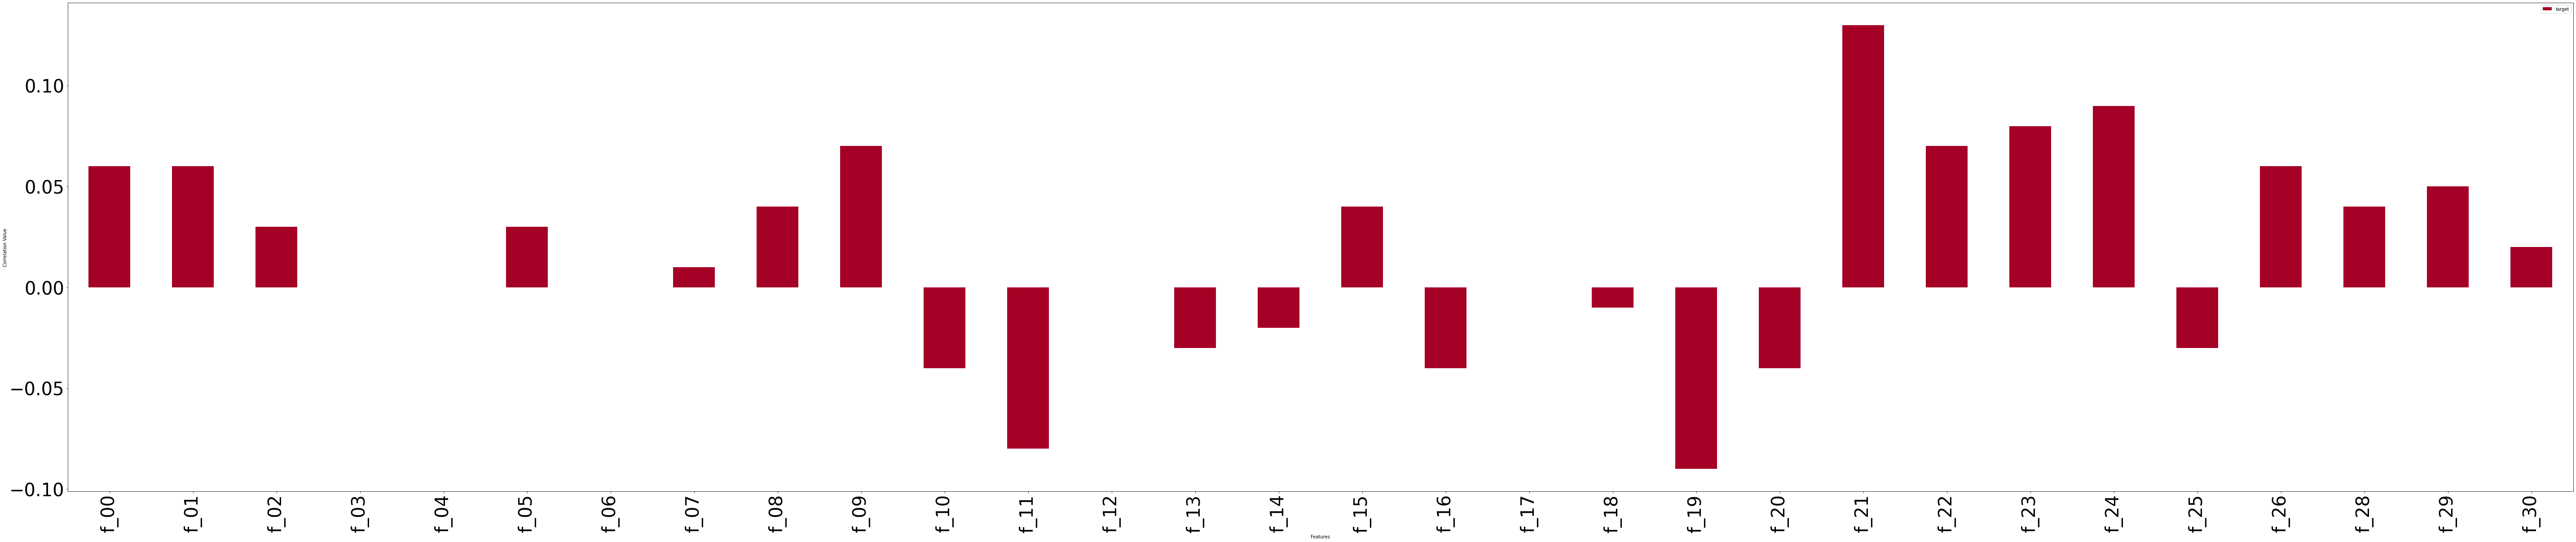

In [10]:
corr.plot(kind = "bar", figsize = (100, 20), colormap = "RdYlBu", xlabel = "Features", ylabel = "Correlation Value",  fontsize = 40, x = "index", y = "target")

In [50]:
np.quantile(corr["target"], .15)

-0.036500000000000005

In [40]:
zero_corr = list(corr[corr["target"] == 0]["index"])
zero_corr

['f_03', 'f_04', 'f_06', 'f_12', 'f_17']

In [11]:
# # creating mask
# mask = np.triu(np.ones_like(train_df.corr()))

# plt.figure(figsize = (50,30))

# # plotting a triangle correlation heatmap
# dataplot = sns.heatmap(train_df.corr(), cmap="YlGnBu", annot=True, mask=mask)
 
# # displaying heatmap
# plt.show()
# # dataplot.plot(figsize = (50, 50))

In [12]:
train_df.columns

Index(['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'target'], dtype='object')

In [13]:
au_corr = pd.DataFrame(train_df.corr().abs())

In [14]:
au_corr = pd.DataFrame(train_df.corr().abs().unstack())
pairs_to_drop = set()
cols = list(train_df.columns)
cols.remove("f_27")
for i in range(0, train_df.shape[1]-1):
    for j in range(0, i+1):
        pairs_to_drop.add((cols[i], cols[j]))
au_corr = au_corr.drop(labels = pairs_to_drop).sort_values(by = 0, ascending = False)
au_corr.reset_index(inplace = True)


In [15]:
print(f'{train_df["f_27"].nunique():,d}'), print(f'{train_df.shape[0]:,d}')

741,354
900,000


(None, None)

In [16]:
enc = OrdinalEncoder()
def feature_eng(df):
    df=df.copy()
    df['char_unique'] = df['f_27'].apply(lambda x: len(set(x)))
    for i in range(df.f_27.str.len().max()):
        df['f_27_char{}'.format(i+1)]=enc.fit_transform(df['f_27'].str.get(i).values.reshape(-1,1))
    return df.drop(['f_27'],axis=1)

train=feature_eng(df=train_df)
test=feature_eng(df=test_df)

In [17]:
# a = enc.fit_transform(train_df['f_27'].str.get(7).values.reshape(-1,1))
# a
# enc.inverse_transform(a)

In [18]:
Y = train['target']
X = train.drop(['target'], axis=1)

In [25]:
# classifier_state_of_art = [('Random Forest', RandomForestClassifier()),
# #                    ('Gradient Boosting',GradientBoostingClassifier()),
#                    ('XGBoost Classifier', XGBClassifier(eval_metric='logloss')),                           
#                    ("LightGBM", LGBMClassifier())]

classifier_state_of_art = [
                   ("Decison Tree", DecisionTreeClassifier()),
                   ("Random Forest", RandomForestClassifier()),
                   ('Gradient Boosting',GradientBoostingClassifier()),
                   ('XGBoost Classifier', XGBClassifier(eval_metric='logloss')),                           
                   ("LightGBM", LGBMClassifier())]

kfold = KFold(n_splits=3, random_state=42, shuffle=True)

score_ls = []
for cl_name, Classifier in classifier_state_of_art:
    cv_results = cross_val_score(Classifier, X ,Y, cv=kfold, scoring="accuracy", n_jobs = -1, verbose = 2)
    scores = "%s: %f (%f)" % (cl_name, cv_results.mean(), cv_results.std())
    print(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   46.8s finished


Decison Tree: 0.764814 (0.001590)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.8min finished


Random Forest: 0.873954 (0.000973)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.9min finished


Gradient Boosting: 0.825801 (0.001585)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


XGBoost Classifier: 0.917519 (0.001022)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.9s finished


LightGBM: 0.889041 (0.000768)


In [30]:
kfold = KFold(n_splits=3, random_state=42, shuffle=True)
clf = XGBClassifier(eval_metric='logloss')
cross_val_score(clf, X, Y, cv=kfold, scoring="accuracy", n_jobs = -1, verbose = 2).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min finished


0.9175188888888889

In [21]:
# Optuna Tuning
def objective_xgb(trial):
    
    kfold = KFold(n_splits=3, random_state=42, shuffle=True)

    n_estimators = trial.suggest_int('n_estimators', 100,500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.5)
    max_depth = trial.suggest_int('max_depth', 4, 32)
    subsample = trial.suggest_uniform('subsample', 0.01, 0.5)
    
#     clf = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, , eval_metric='logloss', use_label_encoder  = False)
    clf = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, subsample = subsample, eval_metric='logloss', use_label_encoder  = False)
    
    return cross_val_score(clf, X, Y, cv=kfold, scoring="accuracy", n_jobs = -1, verbose = 2).mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=3, show_progress_bar = False, n_jobs = -1)

[I 2022-08-07 01:43:28,544] A new study created in memory with name: no-name-0f1dc334-986b-4524-b809-f0fba840cf8c
C:\Users\91903\anaconda3\envs\kali\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.7min finished
[I 2022-08-07 01:50:12,226] Trial 2 finished with value: 0.9226311111111111 and parameters: {'n_estimators': 180, 'learning_rate': 0.36804370634750927, 'max_depth': 15.0, 'subsample': 0.1602744791700611}. Best is trial 2 with value: 0.9226311111111111.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 10.7min finished
[

In [22]:
trial = study.best_trial
print('F1_Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

F1_Score: 0.9239111111111112
Best hyperparameters: {'n_estimators': 388, 'learning_rate': 0.2619378458527501, 'max_depth': 12.0, 'subsample': 0.1174858648754691}


In [24]:
# Optuna Tuning
def objective_rf(trial):
    
    kfold = KFold(n_splits=3, random_state=42, shuffle=True)
    
    n_estimators = trial.suggest_int('n_estimators', 100,500)
    max_depth = trial.suggest_discrete_uniform('max_depth', 1, 32, 1)
    criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
    max_features = trial.suggest_categorical('max_features', ['auto','sqrt','log2'])
    clf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, criterion = criterion, max_features = max_features)
    
    return cross_val_score(clf, X, Y, cv=kfold, scoring="f1", n_jobs = -1, verbose = 2).mean()


study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=10, show_progress_bar = False, n_jobs = -1)

[I 2022-08-07 02:05:45,567] A new study created in memory with name: no-name-61fa3a45-3f3c-4976-a365-bb456528c932
C:\Users\91903\anaconda3\envs\kali\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n

KeyboardInterrupt: 

In [20]:
# Optuna Tuning
def objective_lgbm(trial):
    
    kfold = KFold(n_splits=3, random_state=42, shuffle=True)

    n_estimators = trial.suggest_int('n_estimators', 200,500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.5)
    max_depth = trial.suggest_int('max_depth', 4, 32)
    subsample = trial.suggest_uniform('subsample', 0.01, 0.4)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.2, 1)
    num_leaves = trial.suggest_int('num_leaves', 10,70)
    
    
#     clf = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, , eval_metric='logloss', use_label_encoder  = False)
    clf = LGBMClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, subsample = subsample, colsample_bytree= colsample_bytree, num_leaves = num_leaves)
    
    return cross_val_score(clf, X, Y, cv=kfold, scoring="accuracy", n_jobs = 3, verbose = 2).mean()


study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=15, show_progress_bar = False, n_jobs = -1)

[I 2022-08-08 00:17:08,736] A new study created in memory with name: no-name-d46427e3-8ebd-4c68-8811-4541b59a2205
C:\Users\91903\anaconda3\envs\kali\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using

In [22]:
trial = study_lgbm.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.9465344444444446
Best hyperparameters: {'n_estimators': 487, 'learning_rate': 0.23362341993272462, 'max_depth': 11, 'subsample': 0.2774743124231458, 'colsample_bytree': 0.9657589933885637, 'num_leaves': 53}


In [41]:
train.drop(columns = zero_corr, axis = 1, inplace = True)
test.drop(columns = zero_corr, axis = 1, inplace = True)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [43]:
# params = study_lgbm.best_trial.params
params = {'n_estimators': 487, 'learning_rate': 0.23362341993272462, 'max_depth': 11, 'subsample': 0.2774743124231458, 'colsample_bytree': 0.9657589933885637, 'num_leaves': 53}
clf = LGBMClassifier(**params)
clf.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.9657589933885637,
               learning_rate=0.23362341993272462, max_depth=11,
               n_estimators=487, num_leaves=53, subsample=0.2774743124231458)

In [44]:
from sklearn.metrics import accuracy_score
y_test_pred =clf.predict(X_test)
accuracy=accuracy_score(y_test_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_test_pred)))

LightGBM Model accuracy score: 0.9466


In [20]:
y_pred = clf.predict(test)
test["target"] = y_pred
sub = pd.DataFrame(test[["target"]])

In [27]:
sub.to_csv("submission.csv", index = True)